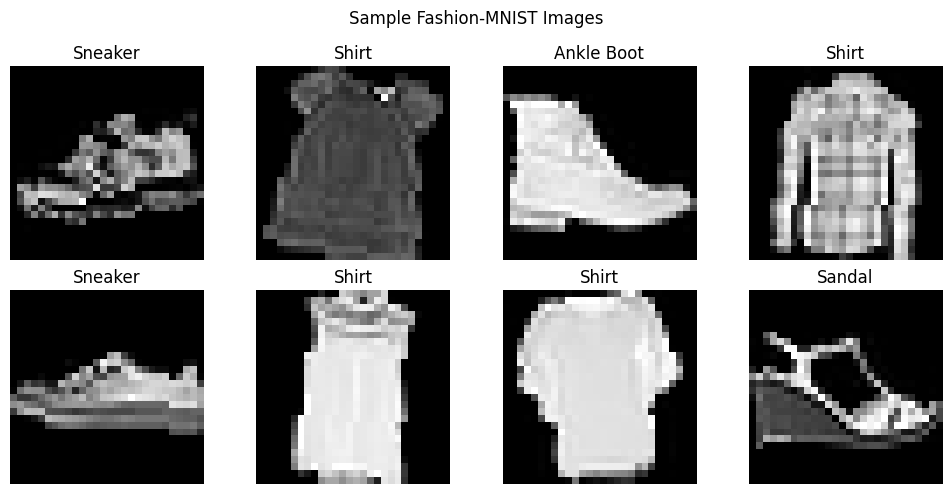


Using device: cuda

Training ANN model...

Epoch [ 1/15] Train Acc:  78.75% | Val Acc:  83.76%
Epoch [ 2/15] Train Acc:  82.32% | Val Acc:  84.79%
Epoch [ 3/15] Train Acc:  83.60% | Val Acc:  84.83%
Epoch [ 4/15] Train Acc:  84.37% | Val Acc:  85.99%
Epoch [ 5/15] Train Acc:  84.84% | Val Acc:  86.38%
Epoch [ 6/15] Train Acc:  86.15% | Val Acc:  87.17%
Epoch [ 7/15] Train Acc:  86.33% | Val Acc:  87.53%
Epoch [ 8/15] Train Acc:  86.85% | Val Acc:  87.38%
Epoch [ 9/15] Train Acc:  86.85% | Val Acc:  87.61%
Epoch [10/15] Train Acc:  87.11% | Val Acc:  87.73%
Epoch [11/15] Train Acc:  87.75% | Val Acc:  88.33%
Epoch [12/15] Train Acc:  87.80% | Val Acc:  88.09%
Epoch [13/15] Train Acc:  88.07% | Val Acc:  88.46%
Epoch [14/15] Train Acc:  88.31% | Val Acc:  88.42%
Epoch [15/15] Train Acc:  88.51% | Val Acc:  88.31%

Training CNN model...

Epoch [ 1/15] Train Acc:  83.72% | Val Acc:  87.04%
Epoch [ 2/15] Train Acc:  88.12% | Val Acc:  88.71%
Epoch [ 3/15] Train Acc:  89.36% | Val Acc:  89.

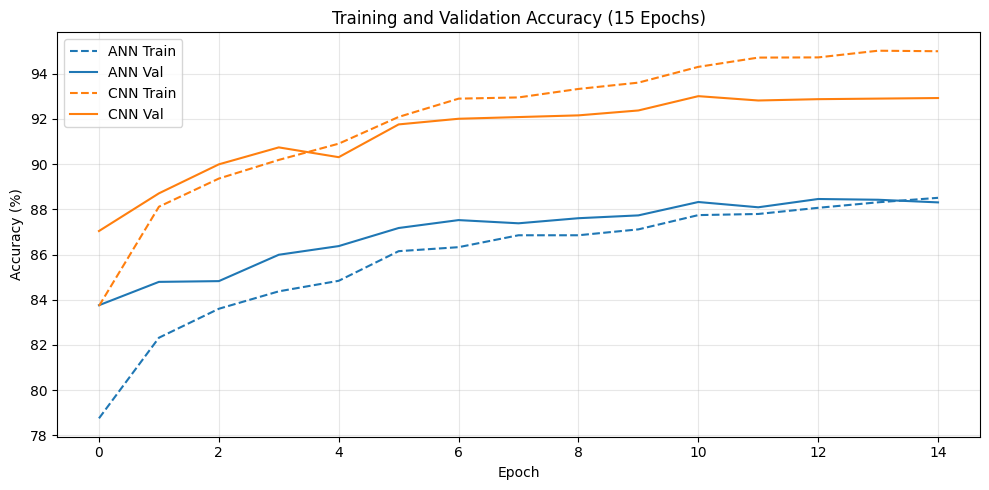

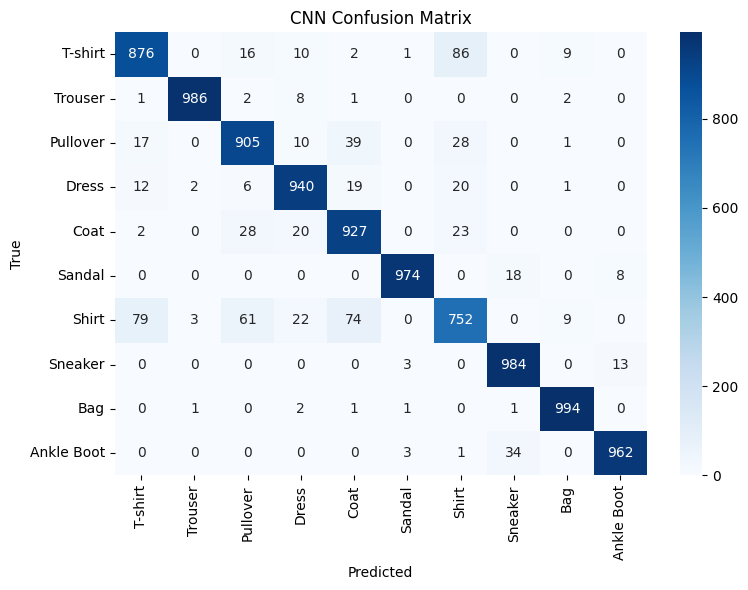

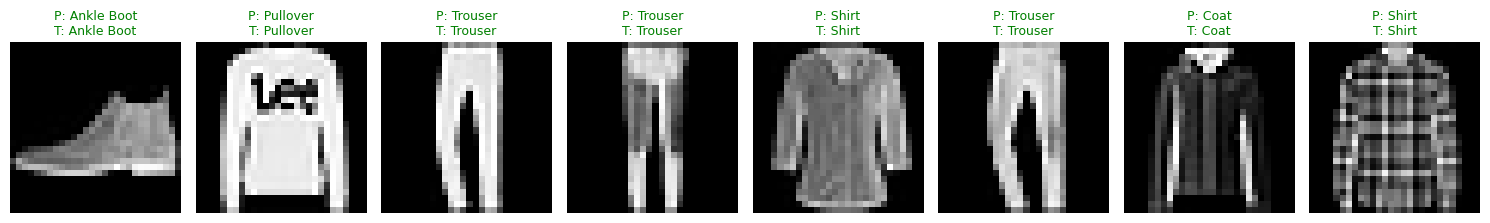


=== ANN Classification Report ===
              precision    recall  f1-score   support

     T-shirt       0.85      0.82      0.84      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.83      0.75      0.79      1000
       Dress       0.87      0.90      0.89      1000
        Coat       0.77      0.83      0.80      1000
      Sandal       0.98      0.93      0.95      1000
       Shirt       0.69      0.72      0.70      1000
     Sneaker       0.92      0.96      0.94      1000
         Bag       0.98      0.97      0.98      1000
  Ankle Boot       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


=== CNN Classification Report ===
              precision    recall  f1-score   support

     T-shirt       0.89      0.88      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pull

In [2]:
# Fashion-MNIST Classification: ANN vs CNN

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Load and Preprocess Dataset
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
test_data  = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)

# Train / Val split (80/20)
train_size = int(0.8 * len(train_data))
val_size   = len(train_data) - train_size
train_set, val_set = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=64, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)

classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

# Show Sample Images (denormalized)
def denormalize(img_tensor):
    """Convert normalized tensor [-1,1] → [0,1]"""
    return img_tensor * 0.5 + 0.5

examples = next(iter(train_loader))
example_data, example_targets = examples

plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    img = denormalize(example_data[i][0]).numpy()
    plt.imshow(img, cmap='gray')
    plt.title(classes[example_targets[i]])
    plt.axis('off')
plt.suptitle("Sample Fashion-MNIST Images")
plt.tight_layout()
plt.show()

# Define Models
# ANN
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


# CNN
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        # Compute flattened size dynamically
        with torch.no_grad():
            sample = torch.zeros(1, 1, 28, 28)
            x = self.pool(F.relu(self.bn1(self.conv1(sample))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = F.relu(self.bn3(self.conv3(x)))
            n_features = x.numel()
        self.fc1 = nn.Linear(n_features, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))   # 28→14
        x = self.pool(F.relu(self.bn2(self.conv2(x))))   # 14→7
        x = F.relu(self.bn3(self.conv3(x)))              # 7×7
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training & Evaluation Functions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}\n")

def train_model(model, train_loader, val_loader, epochs=15, early_stop_patience=None):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    train_acc_list, val_acc_list = [], []
    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(epochs):
        # ---- Train ----
        model.train()
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        train_acc_list.append(train_acc)

        # ---- Validate ----
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        val_acc_list.append(val_acc)
        scheduler.step()

        print(f"Epoch [{epoch+1:2d}/{epochs}] "
              f"Train Acc: {train_acc:6.2f}% | Val Acc: {val_acc:6.2f}%")

        # ---- Early Stopping (optional) ----
        if early_stop_patience is not None:
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                torch.save(model.state_dict(), f"best_{model.__class__.__name__}.pth")
            else:
                patience_counter += 1
                if patience_counter >= early_stop_patience:
                    print("Early stopping triggered!")
                    break

    return train_acc_list, val_acc_list


def test_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

# Train ANN
ann_model = ANNModel().to(device)
print("Training ANN model...\n")
ann_train_acc, ann_val_acc = train_model(
    ann_model, train_loader, val_loader, epochs=15, early_stop_patience=None
)
y_true_ann, y_pred_ann = test_model(ann_model, test_loader)

# Train CNN
cnn_model = CNNModel().to(device)
print("\nTraining CNN model...\n")
cnn_train_acc, cnn_val_acc = train_model(
    cnn_model, train_loader, val_loader, epochs=15, early_stop_patience=None
)
y_true_cnn, y_pred_cnn = test_model(cnn_model, test_loader)

# Plot Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(ann_train_acc, label='ANN Train',   color='tab:blue',   linestyle='--')
plt.plot(ann_val_acc,   label='ANN Val',     color='tab:blue')
plt.plot(cnn_train_acc, label='CNN Train',   color='tab:orange', linestyle='--')
plt.plot(cnn_val_acc,   label='CNN Val',     color='tab:orange')
plt.title("Training and Validation Accuracy (15 Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Confusion Matrix (CNN)
cm = confusion_matrix(y_true_cnn, y_pred_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Visualize Predictions (denormalized)
def visualize_predictions(model, loader, n=8):
    model.eval()
    dataiter = iter(loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        img = denormalize(images[i].cpu().squeeze()).numpy()
        img = np.clip(img, 0, 1)
        plt.imshow(img, cmap='gray')
        color = "green" if preds[i] == labels[i] else "red"
        plt.title(f"P: {classes[preds[i]]}\nT: {classes[labels[i]]}", color=color, fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(cnn_model, test_loader)

# Final Reports
def accuracy(y_true, y_pred):
    return 100 * np.mean(np.array(y_true) == np.array(y_pred))

print("\n=== ANN Classification Report ===")
print(classification_report(y_true_ann, y_pred_ann, target_names=classes))

print("\n=== CNN Classification Report ===")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=classes))

ann_test_acc = accuracy(y_true_ann, y_pred_ann)
cnn_test_acc = accuracy(y_true_cnn, y_pred_cnn)

print(f"\nFinal Test Accuracy:")
print(f"ANN : {ann_test_acc:5.2f}%")
print(f"CNN : {cnn_test_acc:5.2f}%")